# Optimizacija hiperparametrov SVM

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from optuna.pruners import MedianPruner

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)

# Define the Optuna optimization function
def objective(trial):
    # SVM hyperparameters
    C = trial.suggest_float('C', 1e-3, 1.25, log=True)  # Log-uniform sampling
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])  # SVM kernel type
    gamma = trial.suggest_categorical('gamma', ['scale'])
    
    # Feature selection with SelectPercentile
    percentile = trial.suggest_int('percentile', 5, 60)  # Percentile between 5 and 50
    
    # PCA for dimensionality reduction (always included)
    n_components = trial.suggest_float('pca_n_components', 0.1, 0.95)  # PCA float range
    
    # Build the pipeline
    model = Pipeline([
        ('variance_threshold', VarianceThreshold()),  # Remove low-variance features
        ('select_percentile', SelectPercentile(score_func=chi2, percentile=percentile)),  # Feature selection
        ('pca', PCA(n_components=n_components, random_state=kon.random_seed)),  # PCA always included
        ('svm', SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=kon.random_seed))  # SVM Classifier
    ])
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize', pruner=MedianPruner())  # Maximize accuracy
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2024-12-31 19:42:59,916] A new study created in memory with name: no-name-8cc8878e-8f84-4d77-8eb8-6598a6d4cfbd
[I 2024-12-31 19:43:03,036] Trial 0 finished with value: 0.7742309287182221 and parameters: {'C': 0.24166577476017617, 'kernel': 'linear', 'gamma': 'scale', 'percentile': 27, 'pca_n_components': 0.32514832617151795}. Best is trial 0 with value: 0.7742309287182221.
[I 2024-12-31 19:43:05,756] Trial 1 finished with value: 0.8185976040427791 and parameters: {'C': 0.20749171352776238, 'kernel': 'poly', 'gamma': 'scale', 'percentile': 13, 'pca_n_components': 0.7738527485210582}. Best is trial 1 with value: 0.8185976040427791.
[I 2024-12-31 19:43:10,722] Trial 2 finished with value: 0.7189931329259569 and parameters: {'C': 0.017739461211604877, 'kernel': 'poly', 'gamma': 'scale', 'percentile': 55, 'pca_n_components': 0.5209842599599228}. Best is trial 1 with value: 0.8185976040427791.
[I 2024-12-31 19:43:14,475] Trial 3 finished with value: 0.8185994267565265 and parameters: {'C'

Best trial:
  Value: 0.8783584639991251
  Params: {'C': 1.2456514582998646, 'kernel': 'rbf', 'gamma': 'scale', 'percentile': 60, 'pca_n_components': 0.9499415681639852}


Train Accuracy: 0.9342
Test Accuracy: 0.8782
Train AUC: 0.9879
Test AUC: 0.9462


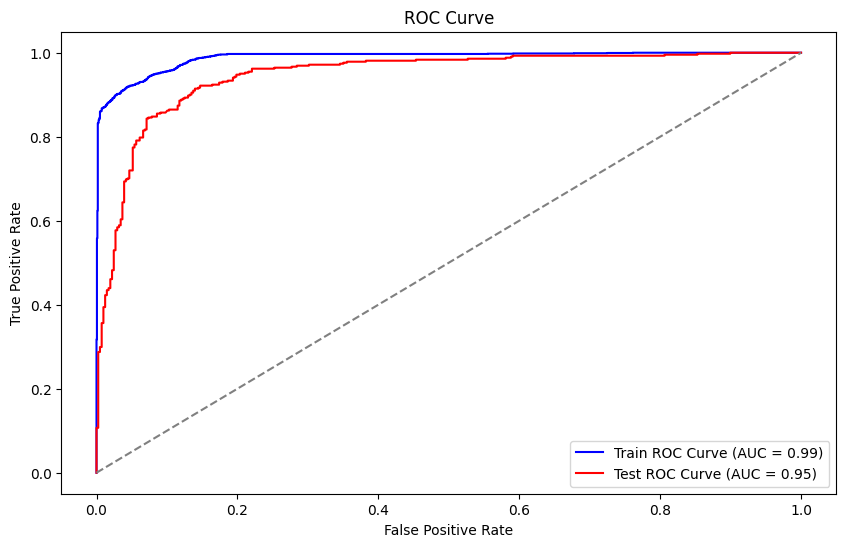

In [3]:
# Extract the best hyperparameters from Optuna
best_params = best_trial.params
C = best_params['C']
kernel = best_params['kernel']
gamma = best_params['gamma']
percentile = best_params['percentile']
pca_n_components = best_params['pca_n_components']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()),  # Remove low variance features
    ('select_percentile', SelectPercentile(score_func=chi2, percentile=percentile)),  # Feature selection
    ('pca', PCA(n_components=pca_n_components, random_state=kon.random_seed)),  # Dimensionality reduction with PCA
    ('svm', SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=kon.random_seed))  # SVM with best parameters
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Print performance metrics
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Train Accuracy: 0.9342
Test Accuracy: 0.8782
Train AUC: 0.9879
Test AUC: 0.9462


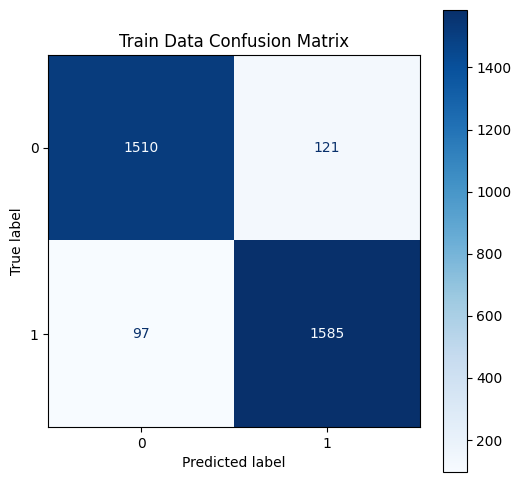

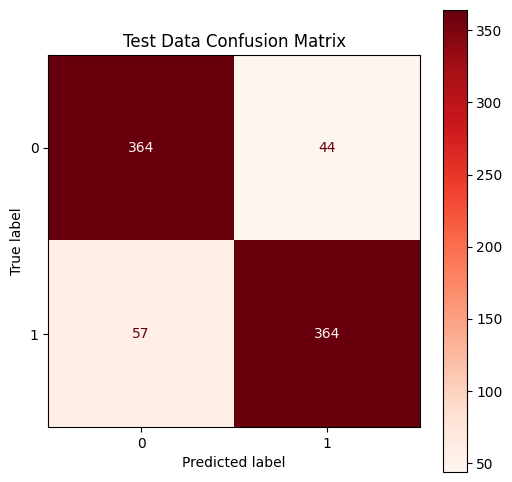

In [4]:
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()